<a href="https://colab.research.google.com/github/hiebschi/MoSE_scripts/blob/main/loop_v01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Implementing a Segmentation Model

## 1. Preparations
### 1.1 Install required packages

In [2]:
import json
import os
import zipfile
import numpy as np
import geopandas as gpd
import sklearn
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision

In [3]:
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.5.1+cu121
torchvision version: 0.20.1+cu121


### 1.2 Install segmentation model

In [4]:
!pip install segmentation-models-pytorch

In [5]:
import segmentation_models_pytorch as smp

### 1.3 Set device agnostic code

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### 1.4 Connect my drive to colab

In [7]:
# manual upload (for small files)
# from google.colab import files
# uploaded = files.upload()

In [8]:
# manual upload through Files Tab (right Tab)
!ls /content

drive  sample_data


In [9]:
# ACCESS TO GOOGLE DRIVE
################################################################################
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 1.5 Set data directories

In [10]:
################################################################################
# Data directories on GOOGLE DRIVE  # -------------------->> ADJUSTABLE
################################################################################
# npy preprocessed patches
preprocessed_patches_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/preprocessed_patches'
# JSON class codes
codes_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/classes'
# Shapefile class labels
labels_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/shapefiles'
# npy Masks
masks_dir = '/content/drive/My Drive/Dokumente.GD/FS06 SS24/BACHELORARBEIT/MoSE/data/masks'

### 1.6 Check the data

1. Class labels and codes

In [11]:
# Load class labels
################################################################################
# specific Shapefile path
shp_path = os.path.join(labels_dir, "GSK_24_WGS84_adjusted.shp") # -------------------->> ADJUSTABLE

labels = gpd.read_file(shp_path) # read shapefile
labels_filtered = labels[labels["Elementtyp"].notnull()] # remove NULL
print(labels_filtered["Elementtyp"].unique()) # print all label classes

['Einzelstein' 'Wurzelstock' 'Steinverbauung' 'Totholz' 'Steinriegel'
 'Schotterbank' 'Schlamm_Sandinsel' 'Sand_Schlammbank' 'Schotterinsel']


In [12]:
# Load class codes
################################################################################
# path
label_codes_path = os.path.join(codes_dir, "label_codes.json")   # -------------------->> ADJUSTABLE

# Open and load the JSON file
with open(label_codes_path, "r") as json_file:
    label_codes = json.load(json_file)

print(label_codes)
len(label_codes)

{'Einzelstein': 1, 'Wurzelstock': 2, 'Steinverbauung': 3, 'Totholz': 4, 'Steinriegel': 5, 'Schotterbank': 6, 'Schlamm_Sandinsel': 7, 'Sand_Schlammbank': 8, 'Schotterinsel': 9}


9

In [13]:
# reversed dictionary
reversed_label_codes = {v: k for k, v in label_codes.items()} # v = value, k = key
reversed_label_codes[4]

'Totholz'

2. Preprocessed patches

In [14]:
################################################################################
# Load preprocessed patches
################################################################################

# list of all .npz-files (.npz-compression)
################################################################################
patches_npz_list = [f for f in os.listdir(preprocessed_patches_dir) if f.endswith('.npz')]
patches_npz_list.sort()
patches_npz_list[0:3]

['A01_patch_0.npy.npz', 'A01_patch_1.npy.npz', 'A01_patch_10.npy.npz']

In [15]:
################################################################################
# SLOW VERSION TO LOAD ALL PATCHES (arrays)
################################################################################

# # empty list for saving loaded arrays (patches)
# patches = []

# for idx, patch_npz_name in enumerate(patches_npz_list): # iterates over all npz-patches in the list
#   patch_npz_path = os.path.join(preprocessed_patches_dir, patch_npz_name) # path to npz-patch

#   with np.load(patch_npz_path) as data: # load npz-patch

#     array_keys = list(data.keys()) # access to array in the npz-patch
#     # print(f"Array Keys: {array_keys}")

#     if len(array_keys) > 1: # if more than 1 array in the npz-patch
#       print(f"WARNING MESSAGE: .npz-file '{patch_npz_name}' contains {len(array_keys)} arrays: {array_keys}") # Warning message

#     patch_name = patch_npz_name.replace(".npz", "") # change to .npy-name
#     array_data = data[array_keys[0]] # extract array data
#     patches.append((patch_name, array_data)) # save as tuple of patch name and corresponding data in the patches list

#     if idx % 100 == 0: # show progress
#       print(f"{idx}/{len(patches_npz_list)} files loaded.")

# print(f"In total {len(patches)} patches successfully loaded.")

In [16]:
################################################################################
# FAST VERSION
################################################################################

# from concurrent.futures import ThreadPoolExecutor, as_completed # import ThreadPoolExecutor for parallelization (parallel loading of patches in each batch)

# # Final list to save loaded patches (name, data)
# patches = []

# # Function to load a single .npz file and extract the first array
# def load_npz_file(file_name, directory):
#     """ Load an .npz file, extract the first array, and return (name, array). """
#     file_path = os.path.join(directory, file_name) # path to .npz-file

#     try:
#         with np.load(file_path) as data:  # Load the .npz file

#             array_keys = list(data.keys())  # Get all keys (array names)

#             if len(array_keys) > 1:  # Print a warning if multiple arrays are present
#                 print(f".npz-file '{file_name}' contains {len(array_keys)} arrays: {array_keys}")

#             patch_name = file_name.replace(".npz", "")  # Remove '.npz' to get the base name
#             array_data = data[array_keys[0]]  # Extract the first array

#             return (patch_name, array_data)  # Return a tuple (name, array)

#     except Exception as e:  # Handle any errors during file loading
#         print(f"Error loading {file_name}: {e}")
#         return None

# # Batch size to load files in chunks
# batch_size = 100

# # Use ThreadPoolExecutor for parallel file loading
# for i in range(0, len(patches_npz_list), batch_size):
#     batch_files = patches_npz_list[i:i + batch_size]  # Get a batch of files
#     print(f"Processing batch {i // batch_size + 1}/{(len(patches_npz_list) // batch_size) + 1}...")

#     # List to temporarily store loaded patches from the current batch
#     batch_patches = []

#     # Parallel loading within the batch
#     with ThreadPoolExecutor(max_workers=8) as executor:  # Adjust max_workers as needed
#         futures = [executor.submit(load_npz_file, file_name, preprocessed_patches_dir) for file_name in batch_files]

#         # Collect results as they are completed
#         for future in as_completed(futures):
#             result = future.result()
#             if result:  # Only append successful results
#                 batch_patches.append(result)

#     patches.extend(batch_patches)  # Add the loaded batch to the final list
#     print(f"Loaded {len(batch_patches)} patches in this batch.")

# # Summary
# print(f"\nIn total {len(patches)} patches successfully loaded.")

Shape of the patches: (3, 512, 512)
Datatype: float64
Type: <class 'numpy.ndarray'>
Mean: -0.5852690845132008
Minimum value: -2.1179039301310043
Maximum value: 2.273986928104575
Minimum and maximum after normalization: 0.0 & 1.0


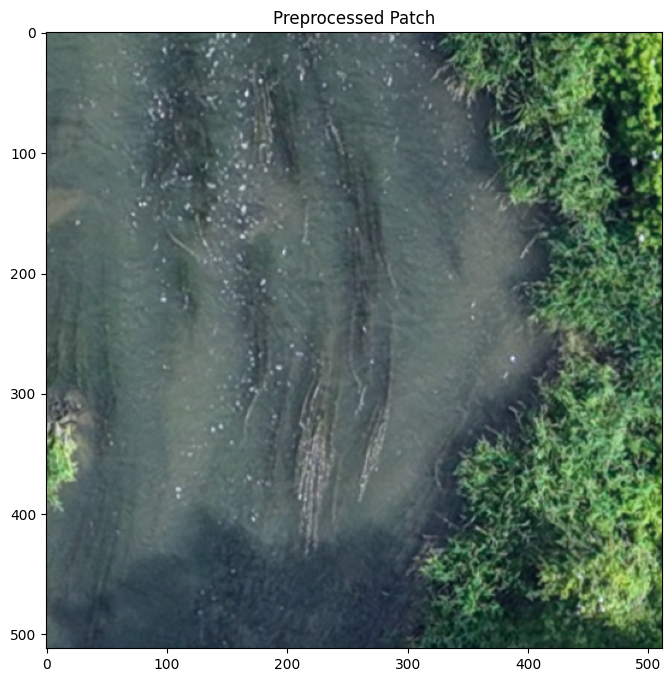

In [17]:
# Test preprocessed patch
################################################################################

##################### choose single patch by section and id
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_PATCH_ID = 16 # -------------------->> ADJUSTABLE
#####################

# load the path to the patch
test_patch_path = preprocessed_patches_dir + f"/{SECTION}_patch_{TEST_PATCH_ID}.npy.npz"

# load npz-file
test_patch_npz = np.load(test_patch_path)
# print(test_pre_patch_npz)

# undo the .npz-compression by extracting the first array
for array in test_patch_npz.files:
  # print(array)
  # extract image data (first array)
  test_patch = test_patch_npz[array]

  # Show properties of the patch
  print("Shape of the patches:", test_patch.shape)
  print("Datatype:", test_patch.dtype)
  print("Type:", type(test_patch))
  print("Mean:", np.mean(test_patch))
  print("Minimum value:", np.min(test_patch))
  print("Maximum value:", np.max(test_patch))

# Normalization of the image data
test_patch_normalized = test_patch - np.min(test_patch ) # set minimum to 0
test_patch_normalized = test_patch_normalized / np.max(test_patch_normalized)  # maximize to 1
print("Minimum and maximum after normalization:", np.min(test_patch_normalized), "&", np.max(test_patch_normalized))

# Plot the preprocessed image
fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(test_patch_normalized.transpose(1, 2, 0))  # transpose for RGB depiction
ax.set_title("Preprocessed Patch")
plt.show()

3. Masks

In [18]:
################################################################################
# Load masks
################################################################################

masks_list = [f for f in os.listdir(masks_dir) if f.endswith('_mask.npy')]  # list of all masks
masks_list.sort() # sort list alphabetically
# masks_list

Shape of the mask: (9, 512, 512)
Datatype: uint8
Type: <class 'numpy.ndarray'>
Minimum value: 0
Maximum value: 1
Unique values: [0 1]


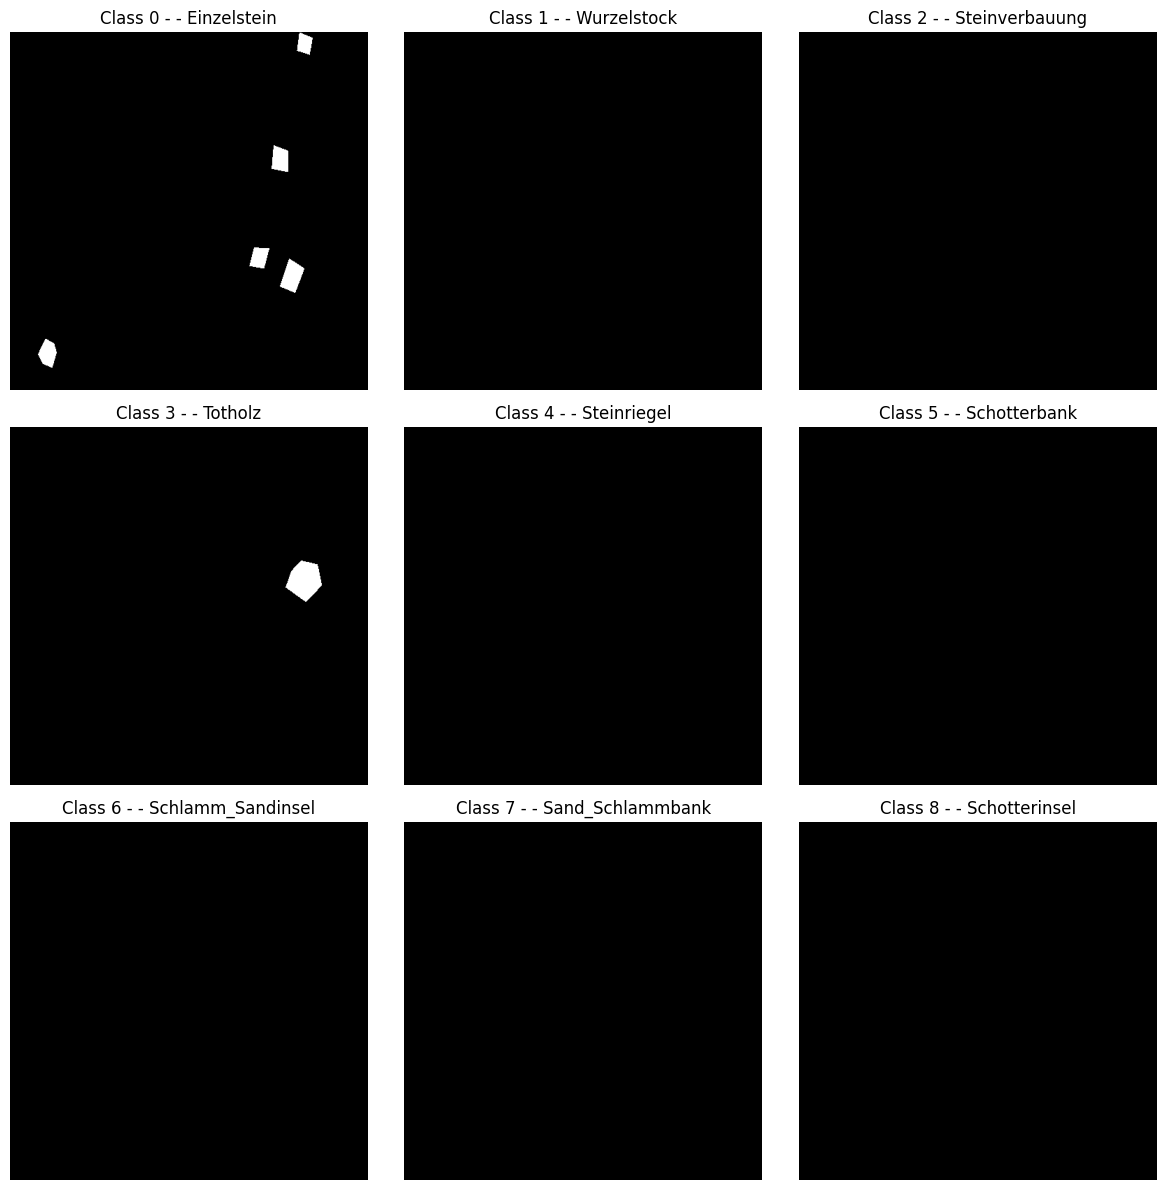

In [19]:
# Test mask
################################################################################

##################### Choose single mask by section and id
SECTION = "A01" # -------------------->> ADJUSTABLE
TEST_MASK_ID = 96 # -------------------->> ADJUSTABLE
#####################

# Path to the chosen mask
test_mask_path = masks_dir + f"/{SECTION}_patch_{TEST_MASK_ID}_mask.npy"

# Load mask
test_mask = np.load(test_mask_path)

# Show properties of the mask
print("Shape of the mask:", test_mask.shape)
print("Datatype:", test_mask.dtype)
print("Type:", type(test_mask))
print("Minimum value:", np.min(test_mask))
print("Maximum value:", np.max(test_mask))
print("Unique values:", np.unique(test_mask)) # binary mask

# Plot the mask
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # 3x3 grid (for 9 masks)
axes = axes.flatten()  # easier to iterate through

for i in range(test_mask.shape[0]):  # iterate through the 9 classes
  axes[i].imshow(test_mask[i], cmap="gray")
  axes[i].set_title(f"Class {i} - - {reversed_label_codes[i + 1]}")
  axes[i].axis("off")

plt.tight_layout()
plt.show()

## 2. Choose and adjust segmentation model

In [20]:
model = smp.Unet(   # -------------------->> ADJUSTABLE
    encoder_name="resnet18",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (3 for RGB)
    classes=len(label_codes),       # model output channels (number of classes)
)

## 3. Splitting data into training and test datasets

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
# pre_patches_list
# masks_list

In [23]:
# helper-function in order to extract section and patch_id
def extract_section_and_id(file_name):
    parts = file_name.split("_") # split condition: _
    section = parts[0]  # extract section from file_name, e.g. "A01"
    patch_id = parts[2].replace(".npy.npz", "").replace("_mask", "") #  extract patch_id, e.g. 481
    return section, patch_id

In [24]:
# print section and patch_id from masks and patches
print(extract_section_and_id(masks_list[1]))
print(extract_section_and_id(patches_npz_list[175]))

('A01', '103')
('A01', '256')


In [25]:
# group patches by section
section_patches = {} # empty dictionary
for patch in patches_npz_list: # iterate over all preprocessed patches
    section, patch_id = extract_section_and_id(patch) # extract section and id
    section_patches.setdefault(section, []).append((patch)) # creates keys of sections with their patches inside

In [26]:
print(section_patches.keys())
# print(section_patches)

dict_keys(['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08'])


In [27]:
# Separate patches in Training and Validation/Test datasets by sections
################################################################################
### HYPERPARAMETER ### -------------------->> ADJUSTABLE
TRAIN_SECTIONS = ["A01", "A02", "A03", "A04", "A05", "A08"]  # Train sections
TEST_SECTIONS = ["A06", "A07"]  # Validation/Test sections
################################################################################

# empty lists for patches
train_data = []
test_data = []

for section, files in section_patches.items(): # iterates through the dictionary of sections
    if section in TRAIN_SECTIONS: # if the section is a training section
        train_data.extend(files) # if yes, the patches are added to the training data
    elif section in TEST_SECTIONS:
        test_data.extend(files)

print(f"Training Patches: {len(train_data)}")
print(f"Test Patches: {len(test_data)}")

Training Patches: 8130
Test Patches: 3043


In [28]:
train_data[8]

'A01_patch_105.npy.npz'

In [29]:
# helper-function to determine whether or not a patch has a corresponding mask
def has_mask(patch_name, masks_dir):

    """ Check if a patch has a corresponding mask in the masks directory.

    Args:
        patch_name (str): Name of the patch (e.g., 'A01_patch_481.npy.npz').
        masks_dir (str): Directory where masks are stored.
    """

    mask_path = os.path.join(masks_dir, patch_name.replace(".npy.npz", "_mask.npy")) # load corresponding mask path
    return os.path.exists(mask_path) # check if path exists

# test helper-function
has_mask(train_data[8], masks_dir)

True

In [30]:
# Separate training and test patches according to whether they have a corresponding mask into label patches and background patches
train_with_masks = [f for f in train_data if has_mask(f, masks_dir)]
# print(train_with_masks)
train_background = [f for f in train_data if not has_mask(f, masks_dir)]
test_with_masks = [f for f in test_data if has_mask(f, masks_dir)]
test_background = [f for f in test_data if not has_mask(f, masks_dir)]

print(f"Training with masks: {len(train_with_masks)}")
print(f"Training background: {len(train_background)}")
print(f"Test with masks: {len(test_with_masks)}")
print(f"Test background: {len(test_background)}")

Training with masks: 2323
Training background: 5807
Test with masks: 724
Test background: 2319


## 4. Dataset and DataLoader

### 4.1 Patch loading functions

In [31]:
# helper-function to load a single .npz file and extract the first array
# function for undoing the .npz-compression! unzip!
def load_npz_patch(patch_npz_name, patches_npz_dir):

    """ Load patch .npz file and undo the .npz compression by extracting the first array and returning it as npy-array.

    Args:
        patch_npz_name (str): Name of the patch .npz file.
        patches_npz_dir (str): Directory where patch .npz files are stored.
    """

    patch_npz_path = os.path.join(patches_npz_dir, patch_npz_name) # path to .npz-file

    try:
        with np.load(patch_npz_path, mmap_mode='r') as data:  # Load the patch .npz-file
        # use memory mapping (mmap_mode='r') for more efficient loading
        # (without loading the total content into RAM)

            array_keys = list(data.keys())  # Get all keys (array names)

            if len(array_keys) > 1:  # Print a warning if multiple arrays are present
                print(f".npz-file '{patch_npz_name}' contains {len(array_keys)} arrays: {array_keys}")

            patch_name = patch_npz_name.replace(".npz", "")  # Remove '.npz' to get the base name

            patch_image = data[array_keys[0]]  # Extract the first array


            return (patch_name, patch_image)

    except Exception as e:  # Handle any errors during file loading
        print(f"Error loading {patch_npz_name}: {e}")
        return None

In [32]:
from concurrent.futures import ThreadPoolExecutor

# Parallel .npz load function
def parallel_load_npz(patches_npz_list, patches_npz_dir):
    with ThreadPoolExecutor() as executor:
        results = list(executor.map(lambda fname: load_npz_patch(fname, patches_npz_dir), patches_npz_list))
    return [res for res in results if res is not None]  # Filter out failed loads

### 4.2 Dataset

In [69]:
from torch.utils.data import Dataset

class PatchDataset(Dataset):
    def __init__(self, patches_npz_list, patches_npz_dir, masks_dir=None, transform=None, preload = False): # initializes the dataset by saving list of .npz-patches, the directory of the .npz-patches and the masks and optional transformations and preloads

        """
        Custom Dataset for loading .npz patches and optional masks.
        Args:
            patches_npz_list (list): List of the patch .npz-files.
            patches_npz_dir (str): Directory containing patch .npz-files.
            masks_dir (str): Directory containing mask.npy files (optional).
            transform (callable, optional): Transformation to be applied to the data.
            preload (bool): Whether to preload all patches into memory.
        """

        self.patches_npz_list = patches_npz_list
        self.patches_npz_dir = patches_npz_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.preload = preload

        if preload:
            # Parallel loading of patches using ThreadPoolExecutor
            print("Preloading patches...")
            self.preloaded_patches = parallel_load_npz(patches_npz_list, patches_npz_dir)
        else:
            self.preloaded_patches = None

    def __len__(self):

        """
        Returns the number of .npz-patches in the dataset.
        """

        return len(self.patches_npz_list) # returns the number of .npz-patches for the DataLoader

    def __getitem__(self, idx): # loads patch and corresponding mask

        """
        Returns the patch and its corresponding mask.

        Args:
            idx (int): Index of the patch in the dataset.
        Returns:
            tuple: A tuple containing the patch and its mask.
        """

        if self.preload and self.preloaded_patches is not None:
            # Use preloaded patch
            patch_name, patch = self.preloaded_patches[idx] # save patch name and patch image data
        else:
            # Load .npz-patch dynamically with patch loading function (see 4.1)
            patch_name, patch = load_npz_patch(self.patches_npz_list[idx], self.patches_npz_dir) # save patch name and patch image data

        # Convert patch into Tensor and change dtype to float32
        patch = torch.tensor(patch, dtype=torch.float32)

        # Load the mask if available
        if self.masks_dir:
            mask_path = os.path.join(self.masks_dir, patch_name.replace(".npy", "_mask.npy"))
            if os.path.exists(mask_path):
                mask = np.load(mask_path) # load mask
                mask = torch.tensor(mask, dtype=torch.long) # convert mask into Tensor and change datatype to long
            else:
                mask = torch.zeros((9, patch.shape[1], patch.shape[2]), dtype=torch.long)  # Create default background mask = all pixels in all channels (= classes) are zeros
        else:
            mask = torch.zeros((9, patch.shape[1], patch.shape[2]), dtype=torch.long)  # Default background mask

        # Apply any transformations if needed
        if self.transform:
            patch, mask = self.transform(patch, mask)

        return patch_name, patch, mask

In [95]:
# Apply Datasets
# Train datasets
train_dataset = PatchDataset(train_with_masks, preprocessed_patches_dir, masks_dir, preload = False) # with masks
# ATTENTION!: "preload = True" leads to crash because of an overuse of cpu-RAM!

# check properties of the mask dataset:
print("Train dataset with class labels:\n")
print("Type of dataset:", type(train_dataset))
print("Number of patches:", len(train_dataset))
print(type(train_dataset[0][0]))
print(train_dataset[0][0])
print(train_dataset[0][1].shape)
print(train_dataset[0][2].shape, "\n")

train_background_dataset = PatchDataset(train_background, preprocessed_patches_dir) # background

# check properties of the background dataset:
print("Train dataset without any class labels = background:\n")
print("Type of dataset:", type(train_background_dataset))
print("Number of patches:", len(train_background_dataset))
print(type(train_background_dataset[0][0]))
print(train_background_dataset[0][0])
print(train_background_dataset[0][1].shape)
print(train_background_dataset[0][2].shape)

# Test datasets
test_dataset = PatchDataset(test_with_masks, preprocessed_patches_dir, masks_dir) # with masks
test_background_dataset = PatchDataset(test_background, preprocessed_patches_dir) # background

Train dataset with class labels:

Type of dataset: <class '__main__.PatchDataset'>
Number of patches: 2323
<class 'str'>
A01_patch_0.npy
torch.Size([3, 512, 512])
torch.Size([9, 512, 512]) 

Train dataset without any class labels = background:

Type of dataset: <class '__main__.PatchDataset'>
Number of patches: 5807
<class 'str'>
A01_patch_10.npy
torch.Size([3, 512, 512])
torch.Size([9, 512, 512])


### 4.3 DataLoader

In [43]:
# Set batch size
# HYPERPARAMETER
##############################
BATCH_SIZE = 10 # -------------------->> ADJUSTABLE
##############################

In [101]:
from torch.utils.data import DataLoader

# Combine Masked and Background datasets into one DataLoader

# Train DataLoader
train_loader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
print(train_loader)
train_background_loader = DataLoader(train_background_dataset, BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)

# Test DataLoader
test_loader = DataLoader(test_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_background_loader = DataLoader(test_background_dataset, BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

print(f"Number of Training Batches: {len(train_loader)}", f"= up to {len(train_loader)*BATCH_SIZE} patches")
print(f"Number of Training Background Batches: {len(train_background_loader)}")
print(f"Number of Test Batches: {len(test_loader)}")
print(f"Number of Test Background Batches: {len(test_background_loader)}")


Number of Training Batches: 233 = up to 2330 patches
Number of Training Background Batches: 581
Number of Test Batches: 73
Number of Test Background Batches: 232


### 4.4 Data exploration

In [114]:
# Explore one batch of data in train_loader
for batch_idx, (names, images, masks) in enumerate(train_loader):
    print(f"Batch {batch_idx + 1}:", "\n------------\n------------")
    print(f"Names - tenth (last) patch name of the batch: {names[9]}", "\n------------")
    print(f"Image type: {type(images)}")
    print(f"Images shape: {images.shape}")  # Should be [batch_size, channels, height, width]
    print(f"Image excerpt of the tenth patch: {images[9,:,:4,:4]}")
    print(f"Images dtype: {images.dtype}", "\n------------")
    print(f"Masks shape: {masks.shape}")    # Should be [batch_size, channels, height, width]
    print(f"Mask excerpt of the mask of the tenth patch: {masks[9,:,:2,:2]}")
    print(f"Masks dtype: {masks.dtype}")
    break

Batch 1: 
------------
------------
Names - tenth (last) patch name of the batch: A05_patch_661.npy 
------------
Image type: <class 'torch.Tensor'>
Images shape: torch.Size([10, 3, 512, 512])
Image excerpt of the tenth patch: tensor([[[0.2796, 0.1597, 0.1083, 0.1083],
         [0.3481, 0.2453, 0.1597, 0.1426],
         [0.3138, 0.2282, 0.1597, 0.1426],
         [0.2282, 0.1597, 0.1254, 0.1083]],

        [[0.3627, 0.2577, 0.2052, 0.2227],
         [0.4678, 0.3627, 0.2752, 0.2577],
         [0.4503, 0.3627, 0.2927, 0.2577],
         [0.3627, 0.3102, 0.2577, 0.2227]],

        [[0.2696, 0.1476, 0.1128, 0.1476],
         [0.3568, 0.2348, 0.1651, 0.1651],
         [0.3393, 0.2173, 0.1825, 0.1651],
         [0.2522, 0.1825, 0.1476, 0.1302]]])
Images dtype: torch.float32 
------------
Masks shape: torch.Size([10, 9, 512, 512])
Mask excerpt of the mask of the tenth patch: tensor([[[0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]],

        [[0, 0],
         [0, 0]],

        [[0, 

In [132]:
# Check label class "Totholz" for one batch in train_loader
for batch_idx, batch in enumerate(train_loader):
    patch_names, images, masks = batch

    # extract mask for class 4 "Totholz"
    class_4_mask = masks[:, 3, :, :]
    print(class_4_mask.shape, "\n") # [batch_size (number of patches), height, width]

    # test if there are any labels for class 4 "Totholz"
    has_class_4_labels = (class_4_mask > 0).any().item()

    # print batch and if there are any labels for class 4
    print(f"Batch {batch_idx + 1}:")
    print(f"Contains class 4 labels: {has_class_4_labels}")

    # if there are any labels for class 4 in one patch, print the names of the patch
    if has_class_4_labels:
        for i, patch_name in enumerate(patch_names):
            if (class_4_mask[i] > 0).any().item():
                print(f"Patch with class 4 labels: {patch_name}")
    break


torch.Size([10, 512, 512]) 

Batch 1:
Contains class 4 labels: True
Patch with class 4 labels: A02_patch_167.npy
Patch with class 4 labels: A03_patch_569.npy
Patch with class 4 labels: A04_patch_340.npy
Patch with class 4 labels: A03_patch_723.npy
Patch with class 4 labels: A05_patch_2258.npy
Patch with class 4 labels: A05_patch_444.npy
Patch with class 4 labels: A03_patch_526.npy
Patch with class 4 labels: A04_patch_957.npy
Patch with class 4 labels: A05_patch_2226.npy


### ?.1 Choose optimizer and loss function

In [ ]:
loss_fn = smp.losses.DiceLoss(mode="multiclass")
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training Loop
num_epochs = 5  # Adjustable number of epochs

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")

    # Set model to training mode
    model.train()
    train_loss = 0.0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images, masks = images.to(device), masks.to(device)  # Move to GPU if available

        # Forward pass
        outputs = model(images)  # Predictions
        loss = loss_fn(outputs, masks)  # Calculate loss

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 10 == 0:  # Display progress every 10 batches
            print(f"Batch {batch_idx + 1}/{len(train_loader)}: Loss = {loss.item()}")

    # Calculate average training loss
    avg_train_loss = train_loss / len(train_loader)
    print(f"Average Training Loss: {avg_train_loss:.4f}")

    # Validation Loop
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # No gradient calculation during validation
        for batch_idx, (images, masks) in enumerate(test_loader):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, masks)

            val_loss += loss.item()

        # Calculate average validation loss
        avg_val_loss = val_loss / len(test_loader)
        print(f"Average Validation Loss: {avg_val_loss:.4f}")

    print("-" * 50)  # Separator for better readability


## Citing

In [ ]:
# @misc{Iakubovskii:2019,
#   Author = {Pavel Iakubovskii},
#   Title = {Segmentation Models Pytorch},
#   Year = {2019},
#   Publisher = {GitHub},
#   Journal = {GitHub repository},
#   Howpublished = {\url{https://github.com/qubvel/segmentation_models.pytorch}}
# }